<a href="https://colab.research.google.com/github/sudo-KingJahad/midterm-machine-learning/blob/main/clustering_midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Langkah 1: Mount Drive dan Load Data

Penjelasan: Langkah ini menyiapkan lingkungan kerja.

1.   Kita menghubungkan Google Drive pribadi Anda ke Google Colab agar file bisa dibaca.
2.   Setelah kode drive.mount dijalankan, akan muncul pop-up izin akses. Klik Connect to Google Drive.
3. PENTING: Karena file ada di dalam folder Google Drive Anda, Anda perlu menentukan lokasi file (path) yang tepat.

    * Setelah mount berhasil, buka ikon Folder di menu kiri Colab.
    * Buka folder drive > MyDrive > cari file clusteringmidterm.csv Anda.
    * Klik kanan file tersebut > pilih Copy path.
    * Tempel (paste) path tersebut ke dalam kode di bagian file_path\.

In [7]:
# Import library untuk koneksi Drive
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Load Dataset
# GANTI path di bawah ini dengan path file CSV Anda yang sebenarnya
# Contoh: '/content/drive/MyDrive/Tugas_Kampus/clusteringmidterm.csv'
file_path = '/content/drive/MyDrive/midterm_folder/clusteringmidterm.csv'

try:
    df = pd.read_csv(file_path)
    print("✅ Data berhasil dimuat!")
    display(df.head())
except FileNotFoundError:
    print("❌ File tidak ditemukan! Pastikan 'file_path' sudah benar sesuai lokasi di Drive Anda.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data berhasil dimuat!


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Langkah 2: Data Preprocessing (Pembersihan Data)

Penjelasan: Agar algoritma bekerja dengan baik, kita perlu membersihkan data:
1. Membuang CUST_ID: ID pelanggan adalah teks unik dan tidak memiliki pola perilaku (hanya identitas), jadi harus dibuang agar tidak mengganggu hitungan matematika.
2. Mengisi Missing Values: Kolom seperti MINIMUM_PAYMENTS sering kosong. Kita isi dengan nilai rata-rata (mean) agar data lengkap.
3. Scaling (Standardisasi): Rentang angka antar kolom berbeda jauh (misal: Saldo bisa ribuan, tapi persentase pembayaran hanya 0-1). Kita ubah semua angka ke skala standar agar algoritma K-Means tidak bias ke angka yang besar saja.

In [9]:
# 1. Hapus CUST_ID (Simpan dulu ID-nya jika butuh nanti, tapi buang dari data latih)
if 'CUST_ID' in df.columns:
    df_clean = df.drop('CUST_ID', axis=1)
else:
    df_clean = df.copy()

# 2. Handling Missing Values (Isi NaN dengan Rata-rata)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

# 3. Scaling / Standardisasi (Wajib untuk Clustering)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_clean.columns)

print("Preprocessing selesai. Data siap untuk clustering.")

Preprocessing selesai. Data siap untuk clustering.


Langkah 3: Menentukan Jumlah Cluster (Metode Elbow)

Penjelasan: Kita tidak tahu berapa kelompok (cluster) yang ideal untuk data ini. Apakah 3 kelompok? Atau 5? Kita gunakan Metode Elbow:
1. Kita coba buat 1 sampai 10 cluster.
2. Kita hitung tingkat error/jaraknya (Inertia).
3. Kita gambar grafiknya. Titik di mana grafik menekuk tajam seperti siku tangan adalah jumlah cluster terbaik.

Sedang menghitung Elbow Method...


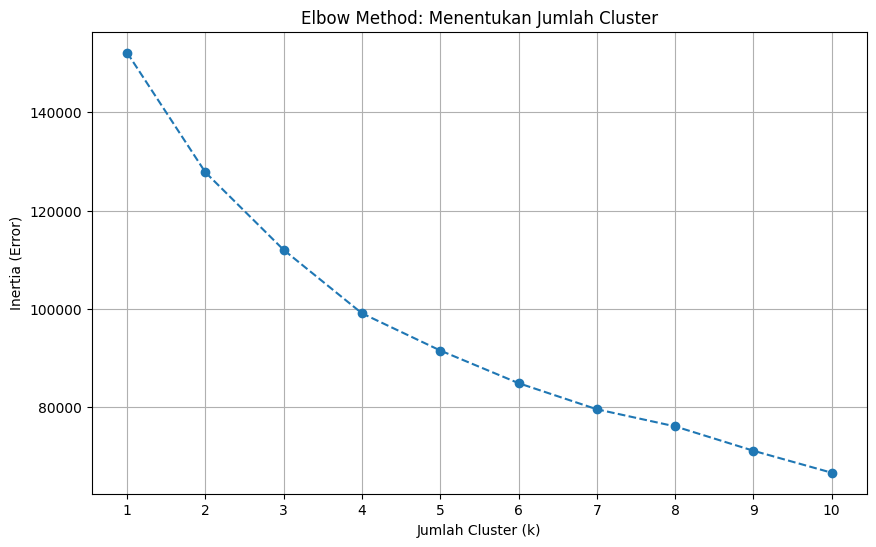

In [10]:
inertia = []
range_k = range(1, 11) # Mencoba k dari 1 sampai 10

print("Sedang menghitung Elbow Method...")

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Visualisasi Grafik Elbow
plt.figure(figsize=(10, 6))
plt.plot(range_k, inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Error)')
plt.xticks(range_k)
plt.grid(True)
plt.show()

Langkah 4: Melatih Model K-Means

Penjelasan: Berdasarkan grafik di atas (biasanya lekukan ada di angka 3 atau 4), kita pilih jumlah cluster tersebut. Misalkan kita pilih 4. Kode ini akan melatih model final dan memberikan "Label" ke setiap pelanggan.

* Pelanggan A -> Masuk Cluster 0
* Pelanggan B -> Masuk Cluster 1, dst.

In [12]:
# Pilih jumlah cluster berdasarkan grafik Elbow (Misal: 4)
k_best = 4

# Latih Model
kmeans_model = KMeans(n_clusters=k_best, random_state=42, n_init=10)
kmeans_model.fit(df_scaled)

# Tambahkan hasil prediksi ke dataframe asli
df['Cluster_Label'] = kmeans_model.labels_

print(f"Model Clustering berhasil dibuat dengan {k_best} cluster.")

Model Clustering berhasil dibuat dengan 4 cluster.


Langkah 5: Visualisasi Cluster (PCA)

Penjelasan: Kita punya 17 kolom data. Manusia tidak bisa melihat grafik 17 dimensi. Kita gunakan teknik PCA (Principal Component Analysis) untuk menyederhanakan 17 kolom tadi menjadi 2 sumbu utama (X dan Y) supaya bisa digambar di layar komputer sebagai titik-titik warna-warni.

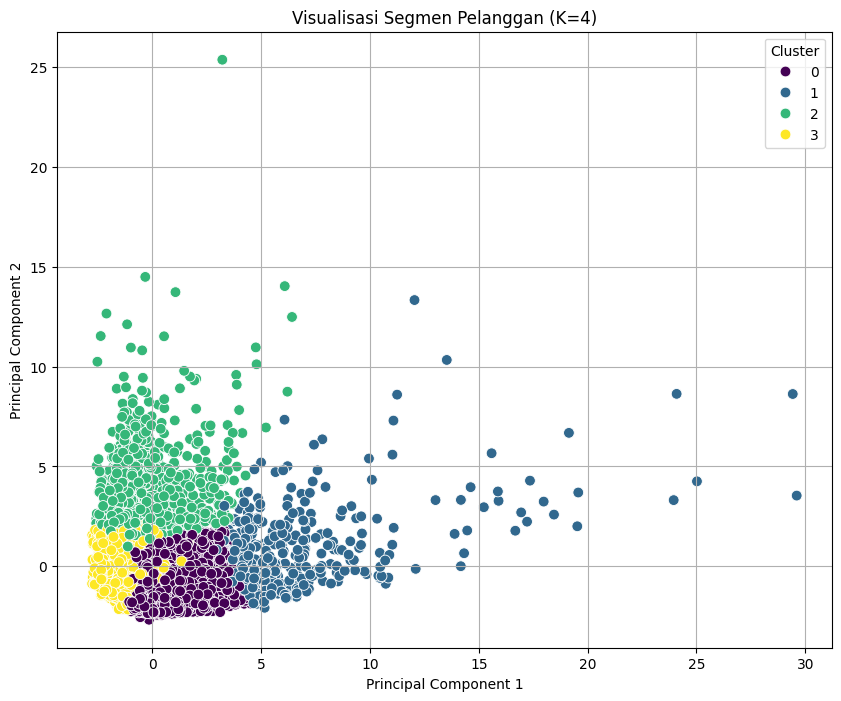

In [13]:
# Reduksi dimensi ke 2D untuk visualisasi
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Buat dataframe sementara untuk plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster_Label']

# Plotting Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=60)
plt.title(f'Visualisasi Segmen Pelanggan (K={k_best})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Langkah 6: Interpretasi Hasil (Analisis Bisnis)

Penjelasan: Langkah terakhir dan terpenting: Membaca Arti Cluster. Kita hitung rata-rata saldo, pembelian, dan penggunaan kartu kredit untuk setiap kelompok. Dari sini kita bisa menamai kelompok tersebut, misalnya:

* "Hemat" (Belanja dikit)
* "Boros" (Belanja banyak, pakai cicilan)
* "Cash User" (Sering tarik tunai)

In [14]:
# Hitung rata-rata fitur per cluster
numeric_cols = df.select_dtypes(include=[np.number]).columns
cluster_summary = df[numeric_cols].groupby('Cluster_Label').mean()

# Fokus pada kolom-kolom penting saja agar mudah dibaca
cols_focus = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']

print("--- RATA-RATA PERILAKU PER CLUSTER ---")
display(cluster_summary[cols_focus])

# Tips membaca output:
print("\nCARA INTERPRETASI:")
print("1. Lihat kolom 'BALANCE': Siapa yang saldonya paling tinggi?")
print("2. Lihat kolom 'PURCHASES': Siapa yang paling sering belanja?")
print("3. Lihat kolom 'CASH_ADVANCE': Siapa yang sering tarik tunai?")

--- RATA-RATA PERILAKU PER CLUSTER ---


,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS
Cluster_Label,,,,,,,
0,894.907458,1236.178934,593.974874,642.478274,210.570626,4213.207678,1332.194205
1,3551.153761,7681.620098,5095.878826,2587.208264,653.638891,9696.943765,7288.739497
2,4602.462714,501.896219,320.373681,181.607404,4520.724309,7546.957050,3481.145990
3,1011.751528,269.973466,209.853863,60.386625,595.759339,3277.397065,974.505090



CARA INTERPRETASI:
1. Lihat kolom 'BALANCE': Siapa yang saldonya paling tinggi?
2. Lihat kolom 'PURCHASES': Siapa yang paling sering belanja?
3. Lihat kolom 'CASH_ADVANCE': Siapa yang sering tarik tunai?
